In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import pandas as pd
import datetime
import copy
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# %matploblib inline

In [2]:
iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
sondeparam_file = f'/global/project/projectdirs/m1657/zfeng/cacti/arm/sounding_stats/Interpsonde_parameters_CACTI_AMF_2Oct-30Apr.nc'
sonde_file = f'/global/project/projectdirs/m1657/zfeng/cacti/arm/sounding_stats/corinterpolatedsondeM1.c1.20181010_20190302_interp3H.nc'
# sonde_file = f'/global/project/projectdirs/m1657/zfeng/cacti/arm/sounding_stats/corinterpolatedsondeM1.c1.20181010_20190302_interp1H.nc'

radar_lat = -32.1264
radar_lon = -64.7284

figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'
figdir_jointhist = f'{figdir}jointhist/'
os.makedirs(figdir, exist_ok=True)
os.makedirs(figdir_jointhist, exist_ok=True)

In [3]:
xr.set_options(display_style='text')

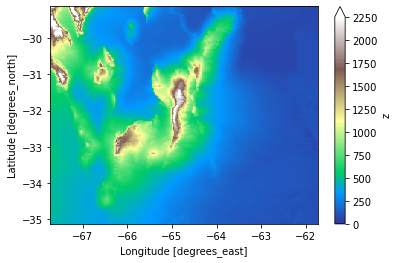

In [4]:
terr = xr.open_dataset(terrain_file)
topoZ = terr['z']
topoLon = terr['x']
topoLat = terr['y']
# topoZ = terr.hgt
# topoLon = terr.longitude
# topoLat = terr.latitude

topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [5]:
# Read interpsonde profile data
dsprof = xr.open_dataset(sonde_file)
dsprof

<xarray.Dataset>
Dimensions:          (height: 332, time: 1153)
Coordinates:
  * height           (height) float32 1.141 1.161 1.181 1.201 ... 68.0 68.5 69.0
  * time             (time) datetime64[ns] 2018-10-10 ... 2019-03-03
Data variables: (12/24)
    base_time        datetime64[ns] ...
    precip           (time) float32 ...
    qc_precip        (time) float32 ...
    temp             (time, height) float32 ...
    qc_temp          (time, height) float32 ...
    source_temp      (time, height) float32 ...
    ...               ...
    sh               (time, height) float32 ...
    qc_sh            (time, height) float32 ...
    rh_scaled        (time, height) float32 ...
    qc_rh_scaled     (time, height) float32 ...
    aqc_rh_scaled    (time, height) float32 ...
    vapor_source     (time, height) float32 ...
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s cor -f M1 -DR ...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     corgriddedsondeM1.c0 : 3.0 : 20181008.000030-20181...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               cor
    ...                    ...
    facility_id:           M1
    data_level:            c1
    location_description:  Cloud, Aerosol, and Complex Terrain Interactions (...
    datastream:            corinterpolatedsondeM1.c1
    doi:                   10.5439/1095316
    history:               created by user dsmgr on machine ruby at 2019-04-1...

In [6]:
# Read sonde data
sonde = xr.open_dataset(sondeparam_file)
sonde

<xarray.Dataset>
Dimensions:                      (len: 6, time: 19776)
Coordinates:
  * time                         (time) datetime64[ns] 2018-10-02 ... 2019-04...
Dimensions without coordinates: len
Data variables: (12/210)
    yyyymmdd                     (time) float64 ...
    hhmmss                       (len, time) |S1 ...
    tallenough_sfc               (time) float64 ...
    CAPE_sfc                     (time) float64 ...
    CIN_NA_sfc                   (time) float64 ...
    CIN_NA_fract_sfc             (time) float64 ...
    ...                           ...
    rvap_diff_grndtoACBL_mu      (time) float64 ...
    rvap_diff_grndtoACBL_sfc     (time) float64 ...
    RH_mean_ACBL                 (time) float64 ...
    RH_min_ACBL                  (time) float64 ...
    DD_mean_ACBL                 (time) float64 ...
    DD_max_ACBL                  (time) float64 ...

In [7]:
# Read 2D track data
stats = xr.open_dataset(stats_file)
time_res = stats.attrs['time_resolution_hour']
pixel_radius = stats.attrs['pixel_radius_km']
stats.dims['tracks']

6895

In [8]:
# # Combine datasets by coordinates
# # stats = xr.combine_by_coords([stats2d, stats3d, sat, sonde], combine_attrs='override')
# stats = xr.combine_by_coords([stats2d, sat, sonde], combine_attrs='override')
# stats.load()
# print(stats)

In [9]:
tracks = stats['tracks']
times = stats['times']
# height = stats['z'] / 1000.
# time_res = stats.attrs['time_resolution_hour']
# pixel_radius = stats.attrs['pixel_radius_km']
print(f'Number of total tracks: {len(tracks)}')

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

# Subset tracks for the entire dataset
stats = stats.isel(tracks=ind)
stats.dims['tracks']

Number of total tracks: 6895
Number of valid tracks: 6887


6887

In [10]:
lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

In [11]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values.astype(int)
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=int)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [12]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 5284
Number of non-split tracks: 5359
Number of non-split tracks within max range: 4854
Number of non-merge tracks within max range: 4528
Number of merge tracks: 1603
Number of split tracks: 1528


In [13]:
cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_area_max = cell_area.max(dim='times')
cell_eth20_max = eth20.max(dim='times')

In [14]:
sonde.keys()

KeysView(<xarray.Dataset>
Dimensions:                      (len: 6, time: 19776)
Coordinates:
  * time                         (time) datetime64[ns] 2018-10-02 ... 2019-04...
Dimensions without coordinates: len
Data variables: (12/210)
    yyyymmdd                     (time) float64 ...
    hhmmss                       (len, time) |S1 ...
    tallenough_sfc               (time) float64 ...
    CAPE_sfc                     (time) float64 ...
    CIN_NA_sfc                   (time) float64 ...
    CIN_NA_fract_sfc             (time) float64 ...
    ...                           ...
    rvap_diff_grndtoACBL_mu      (time) float64 ...
    rvap_diff_grndtoACBL_sfc     (time) float64 ...
    RH_mean_ACBL                 (time) float64 ...
    RH_min_ACBL                  (time) float64 ...
    DD_mean_ACBL                 (time) float64 ...
    DD_max_ACBL                  (time) float64 ...)

In [15]:
# Create a standard time series bins
date_ts = pd.date_range(start='2018-10-15T00', end='2019-03-02T23', freq='6H')
# Make bounds for pcolormesh
date_ts_bounds = pd.date_range(start='2018-10-15T00', end='2019-03-03T00', freq='6H')
ndate_ts = len(date_ts)
print(date_ts)
print(date_ts.shape, date_ts_bounds.shape)

DatetimeIndex(['2018-10-15 00:00:00', '2018-10-15 06:00:00',
               '2018-10-15 12:00:00', '2018-10-15 18:00:00',
               '2018-10-16 00:00:00', '2018-10-16 06:00:00',
               '2018-10-16 12:00:00', '2018-10-16 18:00:00',
               '2018-10-17 00:00:00', '2018-10-17 06:00:00',
               ...
               '2019-02-28 12:00:00', '2019-02-28 18:00:00',
               '2019-03-01 00:00:00', '2019-03-01 06:00:00',
               '2019-03-01 12:00:00', '2019-03-01 18:00:00',
               '2019-03-02 00:00:00', '2019-03-02 06:00:00',
               '2019-03-02 12:00:00', '2019-03-02 18:00:00'],
              dtype='datetime64[ns]', length=556, freq='6H')
(556,) (557,)


In [16]:
# Approximate longitude of SDC ridge
# lon_SDC = -64.9
# lon_eSDC = [-64.9, -63.]
lon_SDC = -65
lon_eSDC = [-65, -63]
idx_eSDC = np.where(start_lon > lon_SDC)[0]
idx_wSDC = np.where(start_lon <= lon_SDC)[0]
ntracks_e = len(idx_eSDC)
ntracks_w = len(idx_wSDC)
print(f'E.SDC ntracks: {ntracks_e}, W.SDC ntracks: {ntracks_w}')

start_time_e = start_time.isel(tracks=idx_eSDC)
start_time_w = start_time.isel(tracks=idx_wSDC)

E.SDC ntracks: 4918, W.SDC ntracks: 1969


In [17]:
bins_area = np.arange(1, 3.41, 0.12)
bins_diam = np.arange(4, 25.1, 1)
bins_eth = np.arange(1, 20.1, 1)
nbins_diam = len(bins_diam)
nbins_area = len(bins_area)
nbins_eth = len(bins_eth)
pdf_celldiam, bins = np.histogram(cell_diam_max, bins=bins_diam, density=True)
pdf_cellarea, bins = np.histogram(np.log10(cell_area_max), bins=bins_area, density=True)
pdf_eth20, bins = np.histogram(cell_eth20_max, bins=bins_eth, density=True)

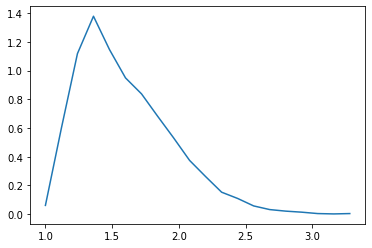

In [18]:
plt.plot(bins_area[:-1], pdf_cellarea)

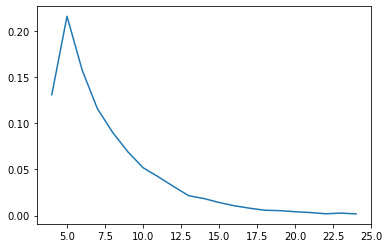

In [19]:
plt.plot(bins_diam[:-1], pdf_celldiam)

In [20]:
# plt.plot(bins_eth[:-1], pdf_eth20)

In [21]:
ntracks_ts = np.full(ndate_ts, np.nan, dtype=float)
ntracks_e_ts = np.full(ndate_ts, np.nan, dtype=float)
ntracks_w_ts = np.full(ndate_ts, np.nan, dtype=float)
cellarea_avg_ts = np.full(ndate_ts, 0, dtype=float)
celldiam_avg_ts = np.full(ndate_ts, 0, dtype=float)
celldiam_pdf_ts = np.full((nbins_diam-1, ndate_ts), 0, dtype=float)
cellarea_pdf_ts = np.full((nbins_area-1, ndate_ts), 0, dtype=float)
celleth20_pdf_ts = np.full((nbins_eth-1, ndate_ts), 0, dtype=float)

for ii in range(ndate_ts-1):
#     print(date_ts[ii])
    idx = np.where((start_time.values >= date_ts[ii]) & (start_time.values < date_ts[ii+1]))[0]
    idx_e = np.where((start_time_e.values >= date_ts[ii]) & (start_time_e.values < date_ts[ii+1]))[0]
    idx_w = np.where((start_time_w.values >= date_ts[ii]) & (start_time_w.values < date_ts[ii+1]))[0]
    count = len(idx)
    count_e = len(idx_e)
    count_w = len(idx_w)
    ntracks_ts[ii] = count
    ntracks_e_ts[ii] = count_e
    ntracks_w_ts[ii] = count_w
#     if count > 0:
    icellarea = cell_area_max.isel(tracks=idx)
    icelldiam = cell_diam_max.isel(tracks=idx)
    ieth20 = cell_eth20_max.isel(tracks=idx)
    cellarea_avg_ts[ii] = np.nanmean(icellarea)
    celldiam_avg_ts[ii] = np.nanmean(icelldiam)
    ipdf, bins = np.histogram(icelldiam, bins=bins_diam, density=False)
    celldiam_pdf_ts[:,ii] = ipdf
    ipdf, bins = np.histogram(np.log10(icellarea), bins=bins_area, density=False)
    cellarea_pdf_ts[:,ii] = ipdf
    ipdf, bins = np.histogram(ieth20, bins=bins_eth, density=False)
    celleth20_pdf_ts[:,ii] = ipdf

<ipython-input-21-d8e39418815d>:25: RuntimeWarning: Mean of empty slice
  cellarea_avg_ts[ii] = np.nanmean(icellarea)
<ipython-input-21-d8e39418815d>:26: RuntimeWarning: Mean of empty slice
  celldiam_avg_ts[ii] = np.nanmean(icelldiam)


<ipython-input-70-eef296d1a9aa>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(date_ts, np.log10(cellarea_avg_ts))


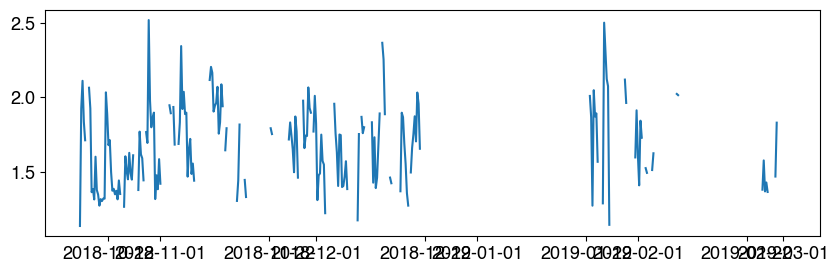

In [70]:
plt.figure(figsize=[10,3], dpi=100)
plt.plot(date_ts, np.log10(cellarea_avg_ts))

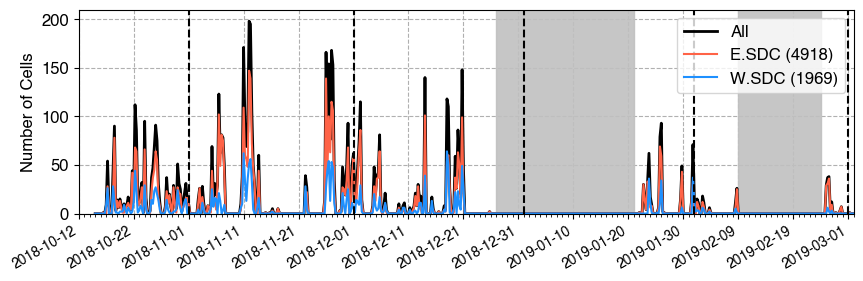

In [61]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax = plt.subplots(1, 1, figsize=[10,3], dpi=100)

outtimes1 = [pd.Timestamp('2018-12-27T00'),  pd.Timestamp('2019-2-9T00')]
outtimes2 = [pd.Timestamp('2019-1-21T00'),  pd.Timestamp('2019-2-24T00')]
monthday1 = pd.date_range(start='2018-10-1', end='2019-3-1', freq='1MS')
xlims = [pd.Timestamp('2018-10-12T00'), pd.Timestamp('2019-3-2T00')]

ax.plot(date_ts, ntracks_ts, color='k', lw=2, label=f'All')
ax.plot(date_ts, ntracks_e_ts, color='tomato', lw=1.5, label=f'E.SDC ({ntracks_e})')
ax.plot(date_ts, ntracks_w_ts, color='dodgerblue', lw=1.5, label=f'W.SDC ({ntracks_w})')
# time_fmt = mdates.DateFormatter('%b %d')
time_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylabel('Number of Cells')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(0,210)
ax.grid(which='major', ls='--')
ax.legend()
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)

fig.autofmt_xdate()
fig.savefig(f'{figdir}cellnumber_timeseries_fullcampaign.png', bbox_inches='tight', dpi=300, facecolor='w')

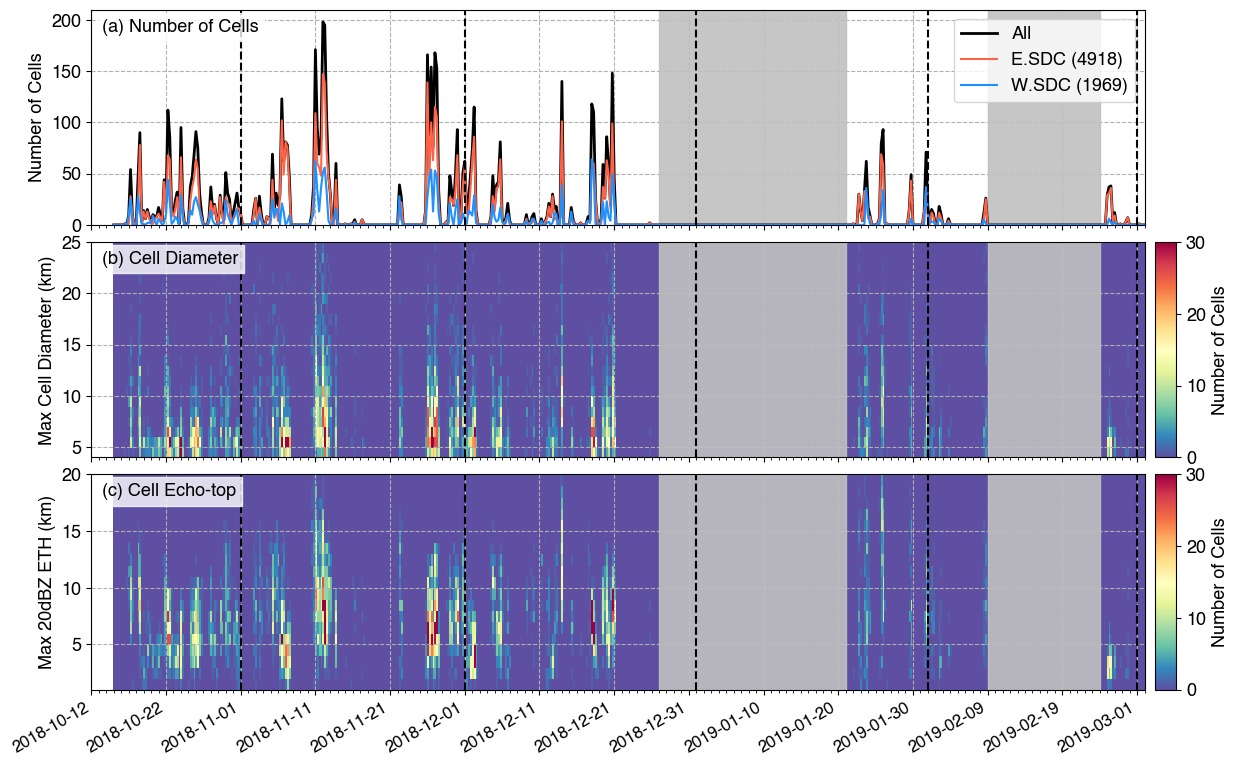

In [62]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[14,10], dpi=100)
gs = gridspec.GridSpec(3,2, height_ratios=[1,1,1], width_ratios=[1,0.02])
gs.update(wspace=0.02, hspace=0.08)

outtimes1 = [pd.Timestamp('2018-12-27T00'),  pd.Timestamp('2019-2-9T00')]
outtimes2 = [pd.Timestamp('2019-1-21T00'),  pd.Timestamp('2019-2-24T00')]
monthday1 = pd.date_range(start='2018-10-1', end='2019-3-1', freq='1MS')
xlims = [pd.Timestamp('2018-10-12T00'), pd.Timestamp('2019-3-2T00')]

# ax = axes[0]
ax = plt.subplot(gs[0,0])
l1 = ax.plot(date_ts, ntracks_ts, color='k', lw=2, label=f'All')
l2 = ax.plot(date_ts, ntracks_e_ts, color='tomato', lw=1.5, label=f'E.SDC ({ntracks_e})')
l3 = ax.plot(date_ts, ntracks_w_ts, color='dodgerblue', lw=1.5, label=f'W.SDC ({ntracks_w})')
time_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Number of Cells')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(0,210)
ax.grid(which='major', ls='--')
ax.legend(loc='upper right')
t1 = ax.text(0.01, 0.9, '(a) Number of Cells', transform=ax.transAxes)
t1.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)
    
ax = plt.subplot(gs[1,0])
pm1 = ax.pcolormesh(date_ts_bounds, bins_diam, celldiam_pdf_ts, shading='flat', vmax=30, cmap='Spectral_r')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Max Cell Diameter (km)')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(4,25)
ax.grid(which='major', ls='--')
t2 = ax.text(0.01, 0.9, '(b) Cell Diameter', transform=ax.transAxes)
t2.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
cax = plt.subplot(gs[1,1])
cb1 = mpl.colorbar.Colorbar(ax=cax, mappable=pm1, label='Number of Cells')
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)

# ax = plt.subplot(gs[1,0])
# pm1 = ax.pcolormesh(date_ts_bounds, bins_area, cellarea_pdf_ts, shading='flat', vmax=30, cmap='Spectral_r')
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# ax.tick_params(axis='x', labelsize=12)
# ax.set_ylabel('Log$_{10}$(Max Cell Area (km))')
# ax.set_xlim(xlims[0], xlims[1])
# ax.set_ylim(1,3.2)
# ax.grid(which='major', ls='--')
# t2 = ax.text(0.01, 0.9, '(b) Cell Area', transform=ax.transAxes)
# t2.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
# cax = plt.subplot(gs[1,1])
# cb1 = mpl.colorbar.Colorbar(ax=cax, mappable=pm1, label='Number of Cells')
# # Plot outtage times
# for ii in range(len(outtimes1)):
#     ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)

ax = plt.subplot(gs[2,0])
pm2 = ax.pcolormesh(date_ts_bounds, bins_eth, celleth20_pdf_ts, shading='flat', vmax=30, cmap='Spectral_r')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Max 20dBZ ETH (km)')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(1,20)
ax.grid(which='major', ls='--')
t2 = ax.text(0.01, 0.9, '(c) Cell Echo-top', transform=ax.transAxes)
t2.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
cax = plt.subplot(gs[2,1])
cb2 = mpl.colorbar.Colorbar(ax=cax, mappable=pm2, label='Number of Cells')
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)
    
fig.autofmt_xdate()
fig.savefig(f'{figdir}cellnumber_diameter_ETH20dBZ_timeseries_fullcampaign.png', bbox_inches='tight', dpi=300, facecolor='w')

(0.0, 6.0)

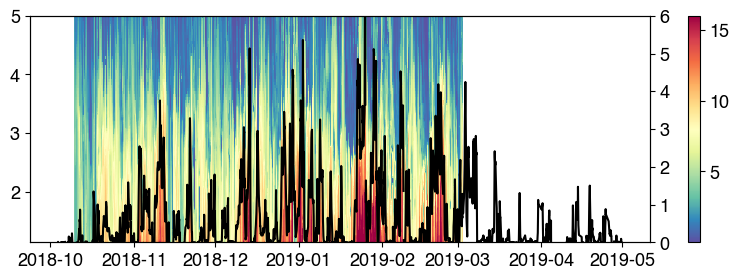

In [28]:
fig, ax1 = plt.subplots(figsize=[10,3], dpi=100)
pcm3 = ax1.pcolormesh(dsprof.time, dsprof.height, dsprof.sh.transpose()*1000, vmax=16, shading='nearest', cmap='Spectral_r')
ax1.set_ylim(1.14, 5)
plt.colorbar(pcm3)

ax2 = ax1.twinx()
ax2.plot(sonde.time, sonde.CAPE_mu/1000., color='k')
ax2.set_ylim(0, 6)

(0.0, 6.0)

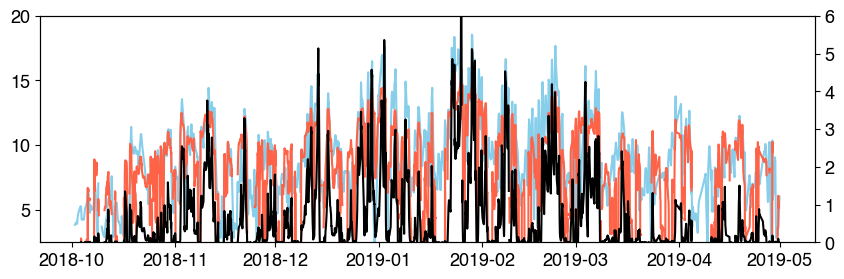

In [80]:
fig, ax = plt.subplots(figsize=[10,3], dpi=100)
l1 = ax.plot(sonde.time, sonde.rvap_850mb, color='skyblue')
l2 = ax.plot(sonde.time, sonde.EL_height_mu/1000, color='tomato')
ax.set_ylim(2.5,20)
# l1 = ax.plot(sonde.time, sonde.PW_interpsonde, color='b')
# l2 = ax.plot(sonde.time, sonde.PW_mwr, color='skyblue')
# ax.set_ylim(0,6)
ax2 = ax.twinx()
ax2.plot(sonde.time, sonde.CAPE_mu/1000, color='k')
ax2.set_ylim(0,6)

(0.0, 18.0)

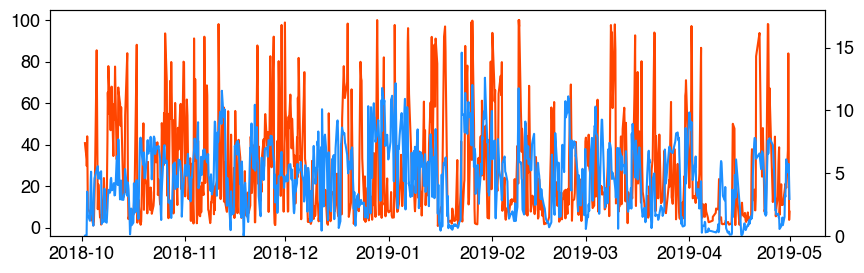

In [75]:
fig, ax = plt.subplots(figsize=[10,3], dpi=100)
l1 = ax.plot(sonde.time, sonde.rh_500mb, color='orangered')
# l1.set_ylim(0,10)
ax2 = ax.twinx()
l2 = ax2.plot(sonde.time, sonde.rvap_700mb, color='dodgerblue')
ax2.set_ylim(0,18)

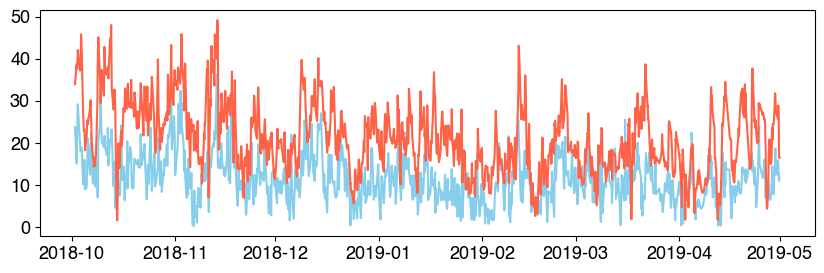

In [67]:
fig, ax = plt.subplots(figsize=[10,3], dpi=100)
l1 = ax.plot(sonde.time, sonde.shear_mag_bulk_0to3km, color='skyblue')
l2 = ax.plot(sonde.time, sonde.shear_mag_bulk_0to6km, color='tomato')

In [55]:
CAPE_mu = sonde.CAPE_mu.values
PW_interpsonde = sonde.PW_interpsonde.values
PW_mwr = sonde.PW_mwr.values
idx = np.where(~np.isnan(CAPE_mu) & ~np.isnan(PW_interpsonde) & ~np.isnan(PW_mwr))[0]
CAPE_mu = CAPE_mu[idx]
PW_interpsonde = PW_interpsonde[idx]
PW_mwr = PW_mwr[idx]
corr_CAPE_PWsonde = np.ma.corrcoef(CAPE_mu, PW_interpsonde, allow_masked=True)
corr_CAPE_PWmwr = np.ma.corrcoef(CAPE_mu, PW_mwr, allow_masked=True)
rho_CAPE_PWsonde = corr_CAPE_PWsonde[0,1]
rho_CAPE_PWmwr = corr_CAPE_PWmwr[0,1]
# np.corrcoef(CAPE_mu, PW_interpsonde)
print(f'CAPE-PWsonde correlation: {rho_CAPE_PWsonde}')
print(f'CAPE-PWmwr correlation: {rho_CAPE_PWmwr}')

CAPE-PWsonde correlation: 0.6053043747873436
CAPE-PWmwr correlation: 0.07482837966342751


In [56]:
sonde.PW_mwr.attrs

{'units': 'cm',
 'description': 'Precipitable water retrieved from microwave radiometer (phys_pwv from mwrret1liljclou VAP)'}

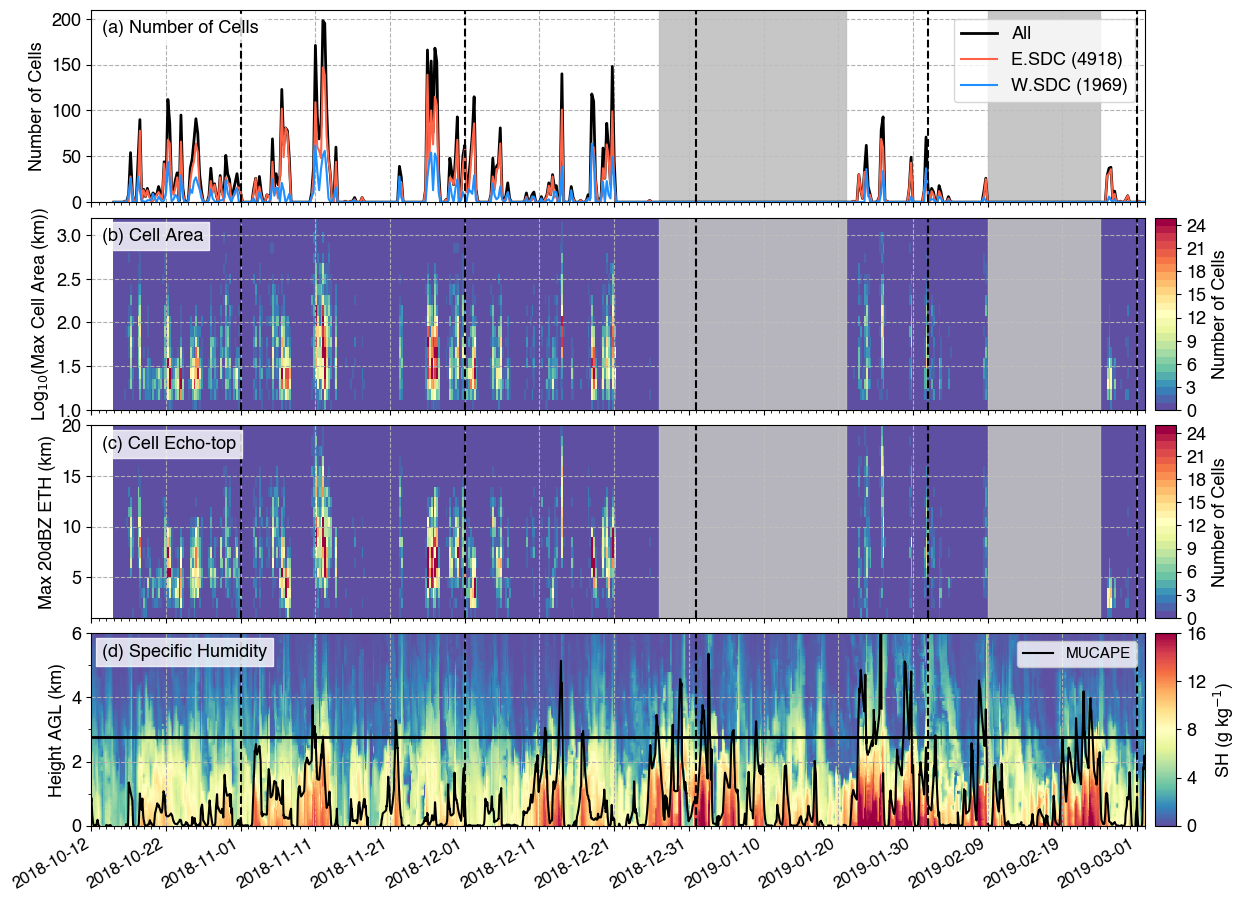

In [60]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[14,12], dpi=100)
gs = gridspec.GridSpec(4,2, height_ratios=[1,1,1,1], width_ratios=[1,0.02])
gs.update(wspace=0.02, hspace=0.08)

outtimes1 = [pd.Timestamp('2018-12-27T00'),  pd.Timestamp('2019-2-9T00')]
outtimes2 = [pd.Timestamp('2019-1-21T00'),  pd.Timestamp('2019-2-24T00')]
monthday1 = pd.date_range(start='2018-10-1', end='2019-3-1', freq='1MS')
time_fmt = mdates.DateFormatter('%Y-%m-%d')
xlims = [pd.Timestamp('2018-10-12T00'), pd.Timestamp('2019-3-2T00')]

# ax = axes[0]
ax = plt.subplot(gs[0,0])
l1 = ax.plot(date_ts, ntracks_ts, color='k', lw=2, label=f'All')
l2 = ax.plot(date_ts, ntracks_e_ts, color='tomato', lw=1.5, label=f'E.SDC ({ntracks_e})')
l3 = ax.plot(date_ts, ntracks_w_ts, color='dodgerblue', lw=1.5, label=f'W.SDC ({ntracks_w})')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Number of Cells')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(0,210)
ax.grid(which='major', ls='--')
ax.legend(loc='upper right')
t1 = ax.text(0.01, 0.88, '(a) Number of Cells', transform=ax.transAxes)
t1.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)
    
ax = plt.subplot(gs[1,0])
cmap = plt.get_cmap('Spectral_r')
levels = np.arange(0, 25.1, 1)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
pm1 = ax.pcolormesh(date_ts_bounds, bins_area, cellarea_pdf_ts, shading='flat', norm=norm, cmap=cmap)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Log$_{10}$(Max Cell Area (km))')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(1,3.2)
ax.grid(which='major', ls='--')
t2 = ax.text(0.01, 0.88, '(b) Cell Area', transform=ax.transAxes)
t2.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
cax = plt.subplot(gs[1,1])
cb1 = mpl.colorbar.Colorbar(ax=cax, mappable=pm1, label='Number of Cells')
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)

ax = plt.subplot(gs[2,0])
cmap = plt.get_cmap('Spectral_r')
levels = np.arange(0, 25.1, 1)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
pm2 = ax.pcolormesh(date_ts_bounds, bins_eth, celleth20_pdf_ts, shading='flat', norm=norm, cmap=cmap)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Max 20dBZ ETH (km)')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(1,20)
ax.grid(which='major', ls='--')
t2 = ax.text(0.01, 0.88, '(c) Cell Echo-top', transform=ax.transAxes)
t2.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
cax = plt.subplot(gs[2,1])
cb2 = mpl.colorbar.Colorbar(ax=cax, mappable=pm2, label='Number of Cells')
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)
    
ax = plt.subplot(gs[3,0])
cmap = plt.get_cmap('Spectral_r')
levels = np.arange(0, 16.1, 0.1)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
pm3 = ax.pcolormesh(dsprof.time, dsprof.height-1.141, dsprof.sh.transpose()*1000, shading='nearest', norm=norm, cmap=cmap)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Height AGL (km)')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(0,6)
# ax.set_yticks(np.arange(0, 6.1, 1))
ax.grid(which='major', ls='--')
t2 = ax.text(0.01, 0.88, '(d) Specific Humidity', transform=ax.transAxes)
t2.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
cax = plt.subplot(gs[3,1])
cb3 = mpl.colorbar.Colorbar(ax=cax, mappable=pm3, label='SH (g kg$^{-1}$)')
cb3.set_ticks(np.arange(0,16.1,4))
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)
ax.axhline(2.77, color='k', lw=2)
# Plot MUCAPE
l4a = ax.plot(sonde.time, sonde.CAPE_mu/1000., color='k', lw=1.5, label='MUCAPE')
# l4b = ax.plot(sonde.time, sonde.PW_interpsonde, color='magenta', lw=1, label='PWV')
ax.legend(loc='upper right', fontsize=11)

fig.autofmt_xdate()
fig.savefig(f'{figdir}cellnumber_area_ETH20dBZ_SH_MUCAPE_timeseries_fullcampaign.png', bbox_inches='tight', dpi=300, facecolor='w')

In [27]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'